#Baseline Model: Random Forest

In [ ]:
!pip install nolds
!pip install keras-tuner
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import nolds
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
def lags(df, lag_feats, lags=(1,2,3)):
    df = df.sort_values("date").reset_index(drop=True)
    for L in lags:
        for feat in lag_feats:
            df[f"{feat}_lag{L}"] = df[feat].shift(L)

    #create lags of the target itself
    for L in lags:
        df[f"label_lag{L}"] = df["label"].shift(L)

    df = df.dropna().reset_index(drop=True)
    return df


def tune_and_evaluate(path):
    df = pd.read_csv(path, parse_dates=["date"])
    # df = lags(df, lag_feats=[
    # " Price Index for Consumer: Energy(electricity, heat, fuel) ",
    # "Crude Oil Prices: Brent - Europe",
    # "euro_stoxx",
    # ], lags=(1,2,3))

    #chronological split
    split = int(len(df)*0.8)
    train, test = df.iloc[:split], df.iloc[split:]
    X_train = train.drop(columns=["date","label"])
    y_train = train["label"]
    X_test  = test.drop(columns=["date","label"])
    y_test  = test["label"]

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
    "n_estimators":      [100, 200, 500],
    "max_depth":         [None, 10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 5, 10],
    "max_features":      ["sqrt", 0.5, 0.8],
    "max_leaf_nodes":    [None, 20, 50, 100],
    "ccp_alpha":         [0.0, 1e-4, 1e-3, 1e-2],
    "bootstrap":         [True, False],
}

    tscv = TimeSeriesSplit(n_splits=4)
    search = RandomizedSearchCV(
        rf, param_dist,
        n_iter=50,
        cv=tscv,
        scoring="r2",
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    preds = best.predict(X_test)

    # After preds = best.predict(X_test)
    # plt.figure(figsize=(10,6))
    # plt.plot(y_test.values, label='True', marker='o')
    # plt.plot(preds, label='Predicted', marker='x')
    # plt.title('True vs Predicted Values')
    # plt.xlabel('Test Sample Index')
    # plt.ylabel('Target Value')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    mse  = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    return {
        "dataset": os.path.basename(path),
        "n_samples": len(df),
        "n_features": X_train.shape[1],
        "best_params": search.best_params_,
        "RMSE": round(rmse, 3),
        "MAE":  round(mean_absolute_error(y_test, preds), 3),
        "R2":   round(r2_score(y_test, preds), 3),
    }

        # Compute residuals
    residuals = y_test - y_pred

    # Residual analysis
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    sns.histplot(residuals, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Histogram of Residuals")

    sns.scatterplot(x=y_test, y=residuals, ax=axes[0, 1])
    axes[0, 1].axhline(0, color='red', linestyle='--')
    axes[0, 1].set_title("Residuals vs Actual")

    plot_acf(residuals, ax=axes[1, 0])
    axes[1, 0].set_title("ACF of Residuals")

    plot_pacf(residuals, ax=axes[1, 1])
    axes[1, 1].set_title("PACF of Residuals")

    plt.tight_layout()
    plt.show()

results = []
# for full_path in ("/content/final_dataset.csv"):
#     results.append(tune_and_evaluate(full_path))

results.append(tune_and_evaluate("/content/final_dataset_1.csv"))

res_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(res_df.to_string(index=False))


            dataset  n_samples  n_features                                                                                                                                                                best_params  RMSE   MAE    R2
final_dataset_1.csv       2370          21 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 0.8, 'max_depth': 50, 'ccp_alpha': 0.001, 'bootstrap': False} 3.903 3.123 0.842


In [ ]:
pd.DataFrame(results).sort_values("R2", ascending=False)

,dataset,n_samples,n_features,best_params,RMSE,MAE,R2
0,final_dataset_1.csv,2370,21,"{'n_estimators': 100, 'min_samples_split': 5, ...",3.903,3.123,0.842


In [ ]:
# # Compute residuals
# residuals = y_test - y_pred

# # Residual analysis
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# sns.histplot(residuals, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Histogram of Residuals")

# sns.scatterplot(x=y_test, y=residuals, ax=axes[0, 1])
# axes[0, 1].axhline(0, color='red', linestyle='--')
# axes[0, 1].set_title("Residuals vs Actual")

# plot_acf(residuals, ax=axes[1, 0])
# axes[1, 0].set_title("ACF of Residuals")

# plot_pacf(residuals, ax=axes[1, 1])
# axes[1, 1].set_title("PACF of Residuals")

# plt.tight_layout()
# plt.show()

#Understanding the data

Correlation Dimension: 0.8689


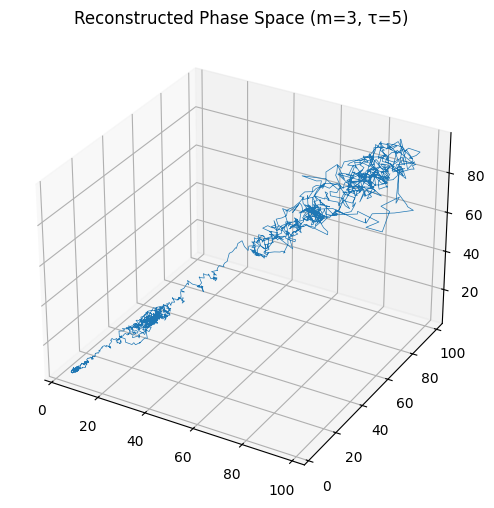

In [ ]:
# Load your dataset
df = pd.read_csv("final_dataset_1.csv")


# Load dataset and drop NaNs
# carbon_series = pd.to_numeric(df["label_lag1"], errors="coerce").dropna().values
carbon_series = pd.to_numeric(df["label"], errors="coerce").dropna().values

# Ensure type is float
carbon_series = carbon_series.astype(np.float64)

# # Recalculate Lyapunov Exponent
# lyap_exp = nolds.lyap_r(carbon_series, emb_dim=6)
# print(f"Maximum Lyapunov Exponent: {lyap_exp:.4f}")

# Recalculate Correlation Dimension
corr_dim = nolds.corr_dim(carbon_series, emb_dim=6)
print(f"Correlation Dimension: {corr_dim:.4f}")

# Phase Space Reconstruction for visualization
def reconstruct_phase_space(series, m=3, tau=5):
    return np.array([series[i:i + m * tau:tau] for i in range(len(series) - (m - 1) * tau)])

reconstructed = reconstruct_phase_space(carbon_series)
reconstructed_df = pd.DataFrame(reconstructed, columns=["x", "y", "z"])

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(reconstructed_df["x"], reconstructed_df["y"], reconstructed_df["z"], lw=0.5)
ax.set_title("Reconstructed Phase Space (m=3, τ=5)")
plt.show()


#FIRST TRIAL OF HYBRID MODEL

##Stage 1: MLP

#Hybrid Model Results

#XGBOOST Model

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor


# Load data
df = pd.read_csv("/content/final_dataset_1.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.dropna()

# Assuming df is already loaded, cleaned, and has no NaNs
# Target and feature separation
target_col = "label"
X = df.drop(columns=["date", target_col], errors='ignore')
y = df[target_col]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Now scale separately on train and apply on test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Define base XGBoost model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Get best model
best_xgb = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ Best XGBoost Params:", grid_search.best_params_)
print("📉 XGBoost Test MSE:", mse)
print("📉 XGBoost Test RMSE:", rmse)
print("📈 XGBoost Test R²:", r2)

# Save residuals for LSTM residual modeling
residuals = y_test - y_pred


Fitting 3 folds for each of 216 candidates, totalling 648 fits
✅ Best XGBoost Params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
📉 XGBoost Test MSE: 8.674076146526577
📉 XGBoost Test RMSE: 2.9451784575007633
📈 XGBoost Test R²: 0.9098056218518357
